In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [78]:
from scipy.signal import sawtooth, square

In [245]:
def custom_sawtooth(freq):
    return sawtooth(freq) + 1

def custom_square(freq):
    return (square(freq) + 1)/2

def custom_triangle(freq):
    return (sawtooth(freq, 0.5) + 1) / 2

stop = 4*2*np.pi / 2
num = 100
freq = np.linspace(start=0, stop=stop, num=num, endpoint=False)

y_square = custom_square(freq)
y_triangle = custom_triangle(freq)
y_sawtooth = custom_sawtooth(freq)

# sns.lineplot(x=freq, y=y_signal)
# plt.show()

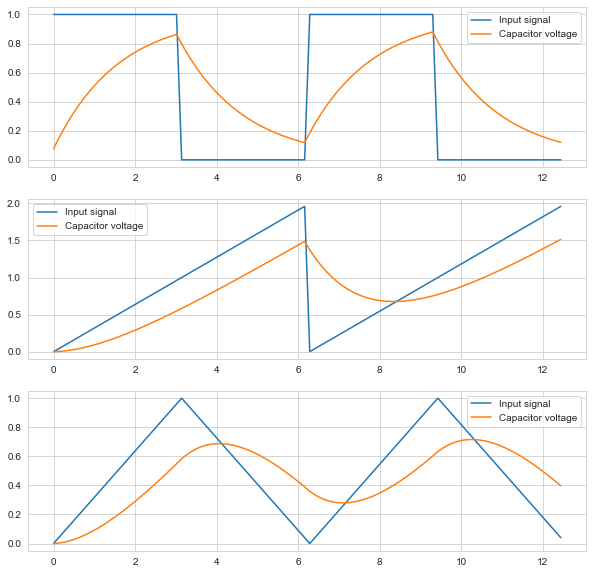

In [251]:
t = 1/stop/num

class Circuit():

    def __init__(self, R, C) -> None:
        self.R = R
        self.C = C
        self.V_stored = 0

    @property
    def tau(self):
        return self.C * self.R

    def process(self, V_input):
        if V_input > self.V_stored:
            V_output = self.charge_circuit(V_input)
        else:
            V_output = self.discharge_circuit(V_input)
        return V_output

    def charge_circuit(self, V_input):
        V_output = V_input - (V_input - self.V_stored) * np.exp(-t/self.tau)
        self.V_stored = V_output
        return V_output

    def discharge_circuit(self, V_input):
        V_output = V_input + (self.V_stored - V_input) * np.exp(-t/self.tau)
        self.V_stored = V_output
        return V_output
    
    def reset_state(self):
        self.V_stored = 0


R, C = 1e3, 1e-5
circuit = Circuit(R, C)

v_output_1 = [circuit.process(V_i) for V_i in y_square]
circuit.reset_state()

v_output_2 = [circuit.process(V_i) for V_i in y_sawtooth]
circuit.reset_state()

v_output_3 = [circuit.process(V_i) for V_i in y_triangle]
circuit.reset_state()

fig, axes = plt.subplots(nrows=3, figsize=(10, 10))

sns.lineplot(x=freq, y=y_square, label="Input signal", ax=axes[0])
sns.lineplot(x=freq, y=v_output_1, label="Capacitor voltage", ax=axes[0])

sns.lineplot(x=freq, y=y_sawtooth, label="Input signal", ax=axes[1])
sns.lineplot(x=freq, y=v_output_2, label="Capacitor voltage", ax=axes[1])

sns.lineplot(x=freq, y=y_triangle, label="Input signal", ax=axes[2])
sns.lineplot(x=freq, y=v_output_3, label="Capacitor voltage", ax=axes[2])


plt.show()

In [ ]:
class CircuitTwin():
    
    def __init__(self, R, C) -> None:
        self.R = R
        self.C = C
        self.V_stored = 0
        self.circuit = Circuit(R, C)

    def set_parameters(self, R, C):
        self.R = R
        self.C = C

    def set_state(self, V_stored):
        self.V_stored = V_stored


In [80]:
# x = np.linspace(start=0, stop=20, num=100)
# x_ramp_up = x[:int(len(x)/2)]
# x_ramp_down = x[int(len(x)/2):]
# y_ramp_up = x_ramp_up/10
# y_ramp_down = -x_ramp_down/10 + 2*np.max(y_ramp_up)
# y = np.hstack((
#     y_ramp_up,
#     y_ramp_down
# ))

# # sns.scatterplot(x=x, y=y)
# sns.lineplot(x=x, y=y)


In [87]:
# 1/(1*2*np.pi)/100

<AxesSubplot:>

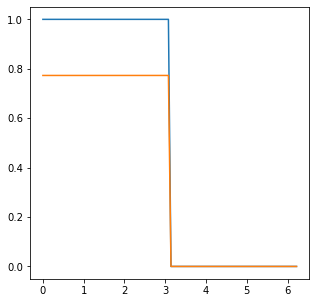

In [186]:
R = 230 #1e3
C = 1e-3
Tau = R*C

def calculate_H(s):
    return 1/(s*Tau + 1)

def calculate_ramp_up(t):
    return t - Tau*(1 - np.exp(-t/Tau))

def calculate_ramp_down(t):
    return t - Tau*(1 - np.exp(-t/Tau))
        # V_output = (V_input) * np.exp(-t/self.tau)

y_ramp_up = y_square[y_square == 1]
y_ramp_down = y_square[y_square == 0]

# sns.lineplot(x=list(range(50)), y=[calculate_H(i) for i in range(50)])
output_ramp_up = calculate_ramp_up(y_ramp_up)
output_ramp_down = calculate_ramp_down(y_ramp_down)
output_ramp = np.hstack((output_ramp_up, output_ramp_down))

fig, axes = plt.subplots(figsize=(5, 5))

# sns.lineplot(x=x_ramp_up, y=output_ramp_up, ax=axes)
# sns.lineplot(x=x_ramp_up, y=y_ramp_up)

sns.lineplot(x=freq, y=y_square, ax=axes)
sns.lineplot(x=freq, y=output_ramp, ax=axes)


In [57]:
output_ramp.shape

(100,)